In [1]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings


In [2]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
DATASET_NAME = 'cstr2'
WINDOW_SIZE = 10

In [4]:
# exclude_columns = ['Fault']

In [5]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False, window_size=WINDOW_SIZE, noise_scale=0.01, use_classes=list(range(0,10)))

In [6]:
# print(timeseries)
# print(labels.head)
print(test_timeseries)
# print(labels['label'])

                          Caf         h          Qf        Ca           T  \
node_id   timestamp                                                         
node_1_10 1          1.016717  6.057370   99.874713  0.036982  405.288766   
          2          1.009830  6.032233  100.088812  0.036948  401.575315   
          3          1.000576  6.048886   99.918453  0.037135  404.402863   
          4          1.001693  5.958278   99.882120  0.036123  401.484403   
          5          1.012373  5.947586  100.732233  0.037095  411.340476   
...                       ...       ...         ...       ...         ...   
node_9_99 95         1.010487  5.951865   98.147710  0.052749  393.817991   
          96         0.999406  6.113649  101.173999  0.052611  402.037448   
          97         0.988051  6.071633  100.293983  0.052700  397.145765   
          98         1.014314  6.009038  101.358084  0.052582  396.214477   
          99         0.997706  5.985377   99.938051  0.052360  392.183682   

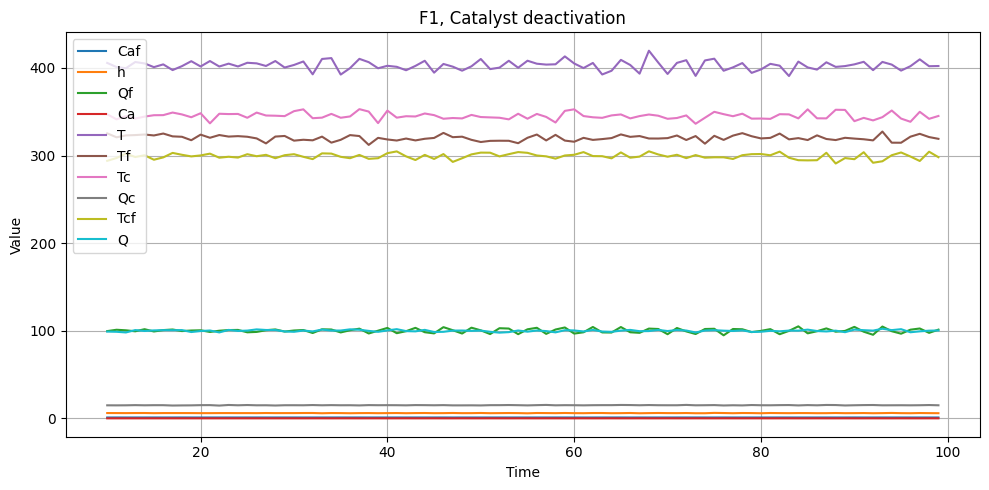

In [7]:
comparison_df=pd.DataFrame(test_timeseries)
comparison_df = comparison_df.groupby(level='node_id').last()
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

for i in range(1,2):
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()
    
    single_node_df_filtered = single_node_df

    # columns_to_plot = ['Ca']
    # single_node_df_filtered = single_node_df[columns_to_plot]    

    # scaler = MinMaxScaler()
    # single_node_df_filtered = pd.DataFrame(scaler.fit_transform(single_node_df_filtered), columns=single_node_df_filtered.columns, index=single_node_df_filtered.index)    
    
    # print(single_node_df_filtered)

    single_node_df_filtered.plot(figsize=(10, 5))
    
    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(100,200))
    # plt.yticks(np.arange(0, 500, step=10))
    # plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df_filtered), step=1), rotation=45)
    # plt.xlim(single_node_df_filtered.index[5], single_node_df_filtered.index[45])
    plt.tight_layout()
    plt.show()


In [8]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100))
], verbose=True)

In [9]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s
[Pipeline] .......... (step 2 of 5) Processing features, total=   4.2s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s


/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.2s


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier())],
         verbose=True)

In [11]:
preds = pipeline.predict(test_timeseries)

In [12]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.8649316400539486
0 0.8222222222222222
1 0.9927007299270073
2 0.9436619718309859
3 0.8671328671328671
4 0.9047619047619048
5 0.859504132231405
6 0.9927007299270073
7 1.0
8 1.0
9 0.3409090909090909


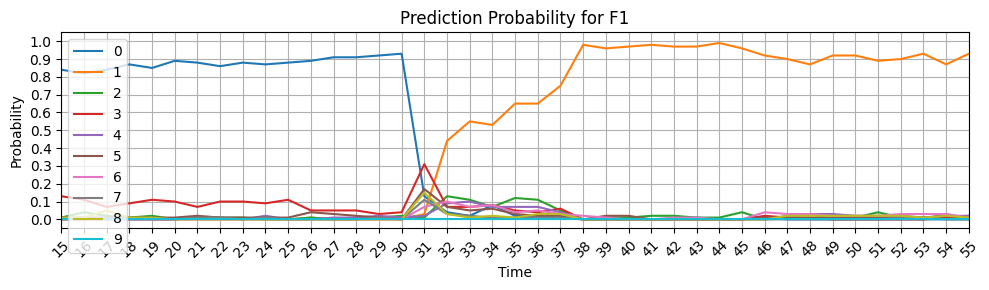

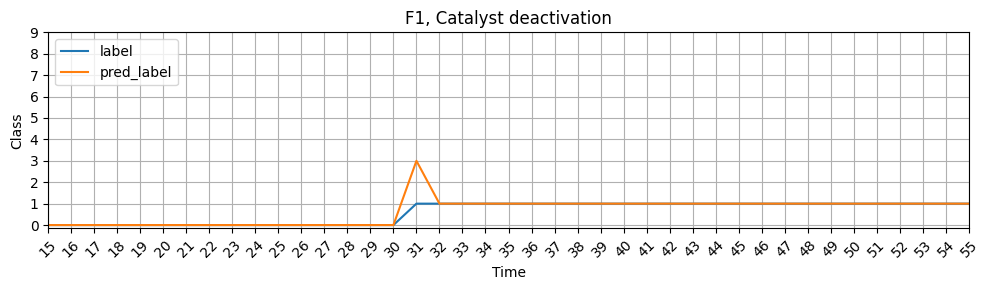

In [13]:
comparison_df=pd.DataFrame(test_labels)
comparison_df['pred_label'] = preds
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

warnings.filterwarnings("ignore")

for i in range(1,2):
    # print(comparison_df)
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()

    # print(single_node_df)
    # plt.figure(figsize=(20, 2))


# Plot prediction probability
    pred_ar = []
    for j in range(WINDOW_SIZE,100):
        loca = "node_{}_{}".format(i,j)
        predi = pipeline.predict_proba(test_timeseries.loc[[loca], :, :])
        pred_ar.append(predi[0])
    pred_df = pd.DataFrame(pred_ar, index=range(WINDOW_SIZE,100))
    # print(pred_df)

    pred_df.plot(figsize=(10, 3))
    plt.title("Prediction Probability for F{}".format(i))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()


    single_node_df.plot(figsize=(10, 3))

    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Class')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 10, step=1))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()

warnings.resetwarnings()


In [14]:
comte = explainers.BruteForceSearch(pipeline, timeseries, labels, silent=False, threads=1,num_distractors=2)

In [16]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 1 #UPDATE HERE FOR OTHER CLASSES
pred_select = 1 #UPDATE HERE FOR OTHER CLASSES
# print(test_labels['label'].values)
# print(preds)
indices_test = []
for idx, (true, pred, node_id) in enumerate(zip(test_labels['label'].values, preds, test_labels['label'].index.get_level_values('node_id'))):
    # if(true!=pred):
    #     print(idx,true,pred)
    if true ==  true_select and pred == pred_select:
        indices_test.append([node_id,idx])
print(indices_test)


[['node_1_32', 22], ['node_1_33', 23], ['node_1_34', 24], ['node_1_35', 25], ['node_1_36', 26], ['node_1_37', 27], ['node_1_38', 28], ['node_1_39', 29], ['node_1_40', 30], ['node_1_41', 31], ['node_1_42', 32], ['node_1_43', 33], ['node_1_44', 34], ['node_1_45', 35], ['node_1_46', 36], ['node_1_47', 37], ['node_1_48', 38], ['node_1_49', 39], ['node_1_50', 40], ['node_1_51', 41], ['node_1_52', 42], ['node_1_53', 43], ['node_1_54', 44], ['node_1_55', 45], ['node_1_56', 46], ['node_1_57', 47], ['node_1_58', 48], ['node_1_59', 49], ['node_1_60', 50], ['node_1_61', 51], ['node_1_62', 52], ['node_1_63', 53], ['node_1_64', 54], ['node_1_65', 55], ['node_1_66', 56], ['node_1_67', 57], ['node_1_68', 58], ['node_1_69', 59], ['node_1_70', 60], ['node_1_71', 61], ['node_1_72', 62], ['node_1_73', 63], ['node_1_74', 64], ['node_1_75', 65], ['node_1_76', 66], ['node_1_77', 67], ['node_1_78', 68], ['node_1_79', 69], ['node_1_80', 70], ['node_1_81', 71], ['node_1_82', 72], ['node_1_83', 73], ['node_1_84

In [17]:
# timeseries.loc[['node_101_32'], :, :]

2024-03-12 13:34:23,762 INFO    Working on turning label from 1 to 0
2024-03-12 13:34:28,141 INFO    Finished constructing per class kdtree
2024-03-12 13:34:28,142 INFO    Returning distractors ['node_101_18', 'node_104_17']
2024-03-12 13:34:28,143 INFO    Trying distractor 1 / 2
2024-03-12 13:34:28,151 INFO    Current probas: [[0.02 0.55 0.11 0.07 0.1  0.05 0.07 0.02 0.01 0.  ]]
2024-03-12 13:34:28,224 INFO    Best column: Ca, best case: 0.98
2024-03-12 13:34:28,239 INFO    Current probas: [[0.98 0.   0.02 0.   0.   0.   0.   0.   0.   0.  ]]
2024-03-12 13:34:28,240 INFO    Trying distractor 2 / 2
2024-03-12 13:34:28,249 INFO    Current probas: [[0.02 0.55 0.11 0.07 0.1  0.05 0.07 0.02 0.01 0.  ]]
2024-03-12 13:34:28,330 INFO    Best column: Ca, best case: 0.98
2024-03-12 13:34:28,345 INFO    Current probas: [[0.98 0.   0.02 0.   0.   0.   0.   0.   0.   0.  ]]


###########
['Ca']
###########


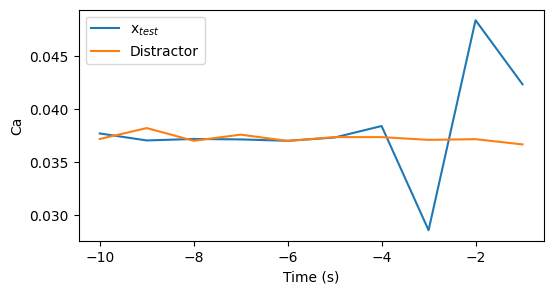

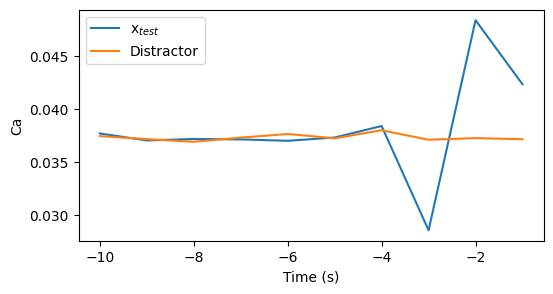

In [18]:
warnings.filterwarnings("ignore")

x_test = test_timeseries.loc[['node_1_33'], :, :]
explanation = comte.explain(x_test,to_maximize=0,savefig=False) 
print('###########') 
print(explanation)
print('###########')

warnings.resetwarnings()

2024-03-12 13:34:28,507 INFO    Working on turning label from 1 to 0
2024-03-12 13:34:28,509 INFO    Min dist:4.2924940784000505 Min dist node:node_101_10
2024-03-12 13:34:28,519 INFO    Min dist:3.660975764739671 Min dist node:node_102_10
2024-03-12 13:34:28,527 INFO    Min dist:3.3877918626520183 Min dist node:node_102_40
2024-03-12 13:34:28,613 INFO    Min dist:3.101802736658386 Min dist node:node_108_39
2024-03-12 13:34:28,626 INFO    Returning distractors ['node_108_39']


###########
['Ca']
###########


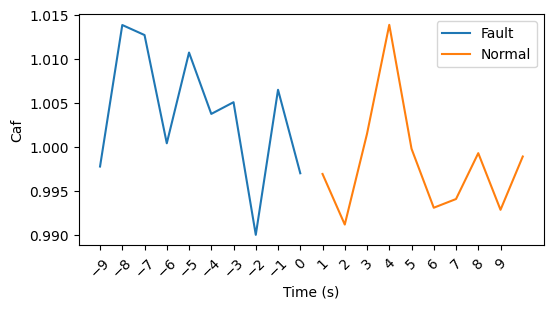

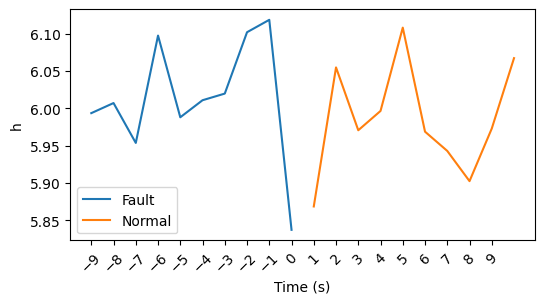

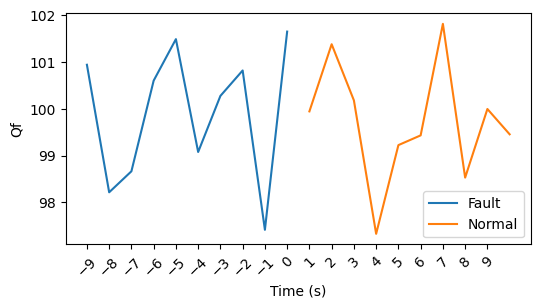

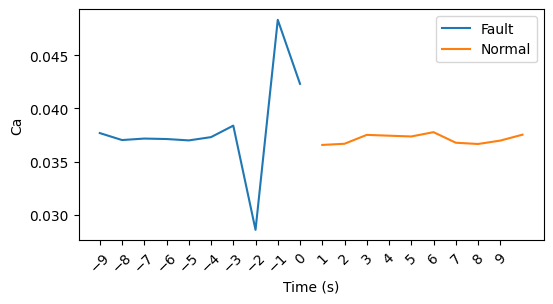

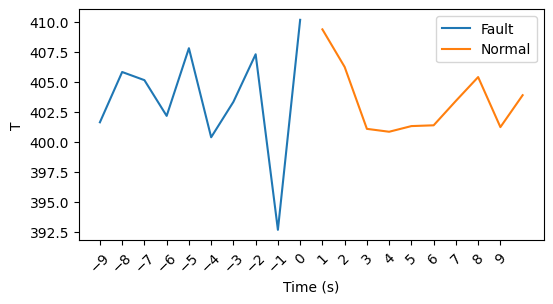

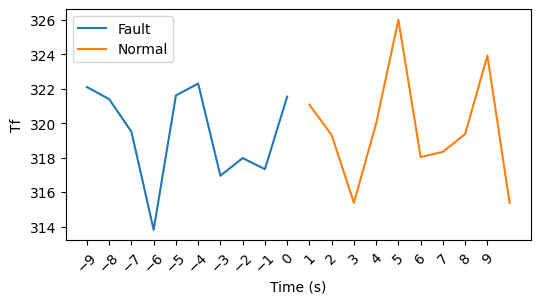

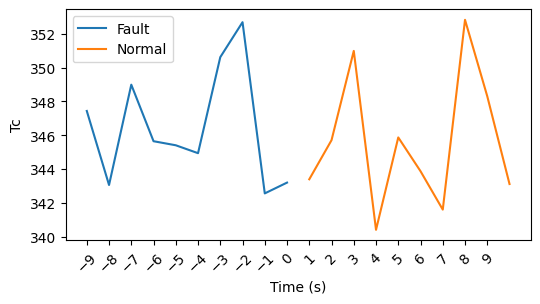

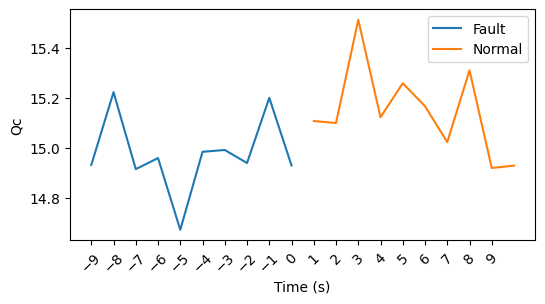

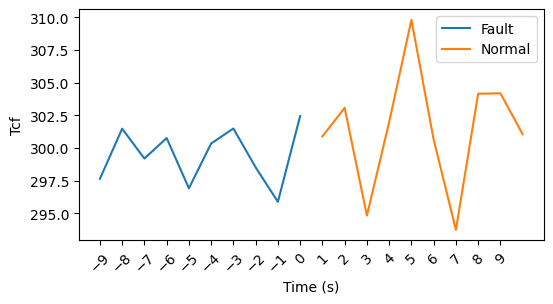

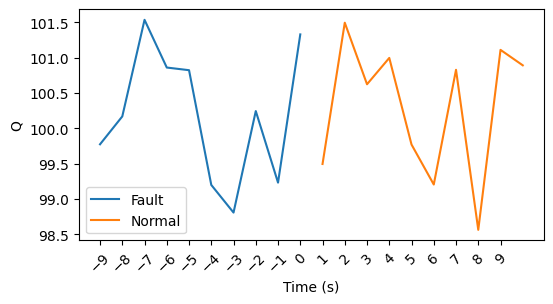

In [19]:
warnings.filterwarnings("ignore")

x_test = test_timeseries.loc[['node_1_33'], :, :]
proto_ts, proto_labels = comte.get_prototype(x_test,to_maximize=0,savefig=False) 
print('###########') 
print(explanation)
print('###########')

warnings.resetwarnings()

In [27]:
proto_preds = pipeline.predict(proto_ts)
# proto_preds
# proto_ts
# # 3 9 15

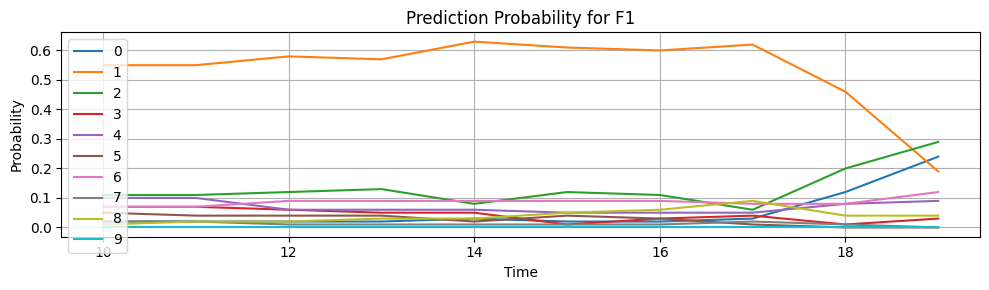

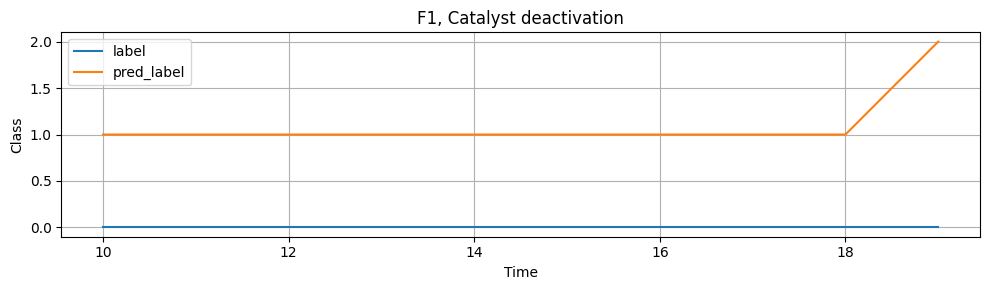

In [28]:
comparison_df=pd.DataFrame(proto_labels)
comparison_df['pred_label'] = proto_preds
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

warnings.filterwarnings("ignore")

for i in range(1,2):
    # print(comparison_df)
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()

    # print(single_node_df)
    # plt.figure(figsize=(20, 2))


# Plot prediction probability
    pred_ar = []
    for j in range(WINDOW_SIZE,20):
        loca = "node_{}_{}".format(i,j)
        predi = pipeline.predict_proba(proto_ts.loc[[loca], :, :])
        pred_ar.append(predi[0])
    pred_df = pd.DataFrame(pred_ar, index=range(WINDOW_SIZE,20))
    # print(pred_df)

    pred_df.plot(figsize=(10, 3))
    plt.title("Prediction Probability for F{}".format(i))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.yticks(np.arange(0, 1.1, step=0.1))
    # plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    # plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()


    single_node_df.plot(figsize=(10, 3))

    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Class')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.yticks(np.arange(0, 10, step=1))
    # plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    # plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()

warnings.resetwarnings()


In [29]:
# proto_ts.loc[['node_1_10'], :, :]
# # pipeline.predict_proba(proto_ts.loc[['node_1_10'], :, :])
# test_timeseries.loc[['node_1_33'], :, :]
# timeseries.loc[['node_101_30'], :, :]

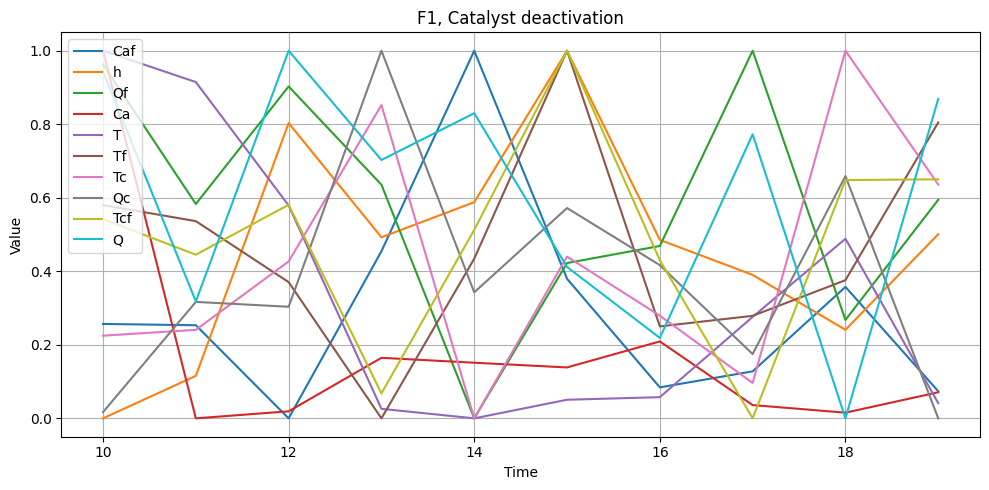

In [30]:
comparison_df=pd.DataFrame(proto_ts)
comparison_df = comparison_df.groupby(level='node_id').last()
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

for i in range(1,2):
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()
    
    single_node_df_filtered = single_node_df

    # columns_to_plot = ['Ca']
    # single_node_df_filtered = single_node_df[columns_to_plot]    

    scaler = MinMaxScaler()
    single_node_df_filtered = pd.DataFrame(scaler.fit_transform(single_node_df_filtered), columns=single_node_df_filtered.columns, index=single_node_df_filtered.index)    
    
    # print(single_node_df_filtered)

    single_node_df_filtered.plot(figsize=(10, 5))
    
    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(100,200))
    # plt.yticks(np.arange(0, 500, step=10))
    # plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df_filtered), step=1), rotation=45)
    # plt.xlim(single_node_df_filtered.index[5], single_node_df_filtered.index[45])
    plt.tight_layout()
    plt.show()
